# Estimating a model with a known number of events

This section will show you how to estimate a single HMP model with a given number of events, as in the previous tutorial, but now we'll make it more realistic and harder to discover.

First we do more or less the same as in the previous tutorial:
- simulate EEG data
- transform the data
- initialize a model with default parameters for distribution, shape and event duration

We now simulate the data by calling the `demo` function, which is only used for this tutorial.

[!IMPORTANT] If you're running this for the first time a 1.65 G file will be downloaded by MNE python in order to perform the simulation but this will be done only once (alternatively you can just download the corresponding simulation file and place it in the same folder from where you are running this notebook)

In [1]:
## Importing the package
import hmp
#Plotting 
import numpy as np
import matplotlib.pyplot as plt

cpus = 5 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM
import multiprocessing as mp
#When using multiple CPUs explicitely setting the context of the multiprocessing is needed
#The following line works in most environment
mp.set_start_method("spawn")
#If multiprocessing errors/warning still present comment previous line and uncomment this one
# mp.set_start_method("fork")


## Running the demo function in the simulation module
# Inspect the given function to apply your own simulations
from hmp.simulations import demo
n_events = 8 #how many events to simulate
seed = 123 #change to simulate other similar datasets
epoch_data, sim_source_times, info = demo(cpus, n_events, seed=seed)

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:190: UserWarning: ./dataset_tutorial2_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)
/home/gweindel/miniconda3/envs/main_hmp/lib/python3.12/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


Processing participant ./dataset_tutorial2_raw.fif's continuous eeg
50 trials were retained for participant ./dataset_tutorial2_raw.fif


We specify directly that we want 10 PC components (in real data mor component is better, but more component also increases number of parameters and thus complexity to estimate):

In [2]:
hmp_dat = hmp.utils.transform_data(epoch_data, n_comp=10)
print(hmp_dat)

<xarray.DataArray (component: 10, all_samples: 9476)> Size: 758kB
array([[ 0.39687211,  0.03357449,  0.05369454, ..., -0.1313086 ,
        -0.26032513, -0.33323305],
       [-0.73132737, -0.37044761, -0.51221659, ..., -0.38217725,
         0.01196829,  0.1487548 ],
       [-0.91774172, -0.64577128, -0.07453543, ..., -0.43914342,
        -0.90453939, -1.18642197],
       ...,
       [ 0.65861775,  0.94662213,  0.76625374, ...,  0.30885386,
         0.52105993,  0.59201441],
       [ 1.13775838,  1.86272129,  1.44273558, ...,  0.44889157,
         1.06108658,  1.05645553],
       [ 0.82427604,  0.45522012, -0.23719251, ...,  0.43962836,
         0.2335529 ,  0.36290905]])
Coordinates:
    event_name   (all_samples) object 76kB 'stimulus' 'stimulus' ... 'stimulus'
    rt           (all_samples) float64 76kB 0.712 0.712 0.712 ... 0.84 0.84 0.84
  * component    (component) int64 80B 0 1 2 3 4 5 6 7 8 9
  * all_samples  (all_samples) object 76kB MultiIndex
  * participant  (all_samples) <U2

And we initialize the model:

In [3]:
init = hmp.models.hmp(hmp_dat, event_width=50, cpus=cpus)#Initialization of the model

Once the class has been initiated, the function ```fit_n()``` can be used to estimate one hmp model with a specified number of transition events

## Direct estimation
As in the previous tutorial, we can simply call the ```fit_n``` method from the hmp class to estimate a given number of events. The hmp algorithm will then look for ```n_event``` events. 

Unfortunately, the expectation maximization algorithm to fit the model is sensitive to the starting points given to the relative event onsets. By default, the ```fit_n``` method uses a starting point where all events are equally distributed between 0 and the mean RT, and the magnitudes are set to 0.

Estimating 8 events model with 1 starting point(s)
parameters estimated for 8 events model


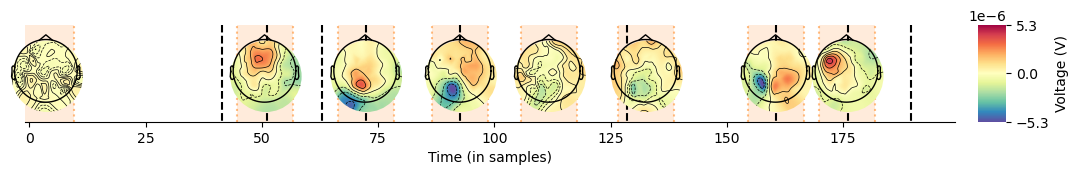

In [4]:
#Fitting
selected = init.fit_n(n_events)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As you can see, the method discovers 8 events - as we told it to - but two of them are at the wrong location (the vertical lines indicate the true event locations). What happens is that the first ones are too close together to be found by the default starting points.

Thus, launching a single model without additional starting points is not a good idea as sometimes the default starting values of the expectation maximization algorithm will end up in a local minima, as above.

To see what happens if we just use the default inputs and set maximization to False:

Estimating 8 events model with 1 starting point(s)
parameters estimated for 8 events model


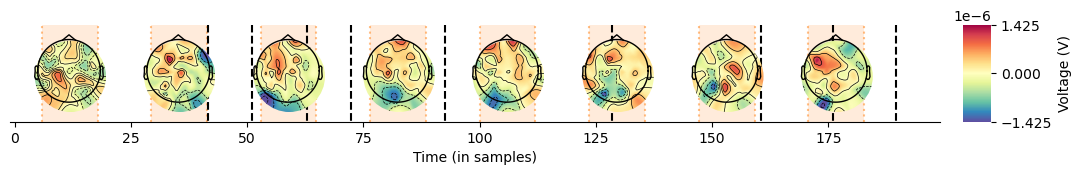

In [5]:
#Fitting
selected = init.fit_n(n_events, maximization=False)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, magnify=1, sensors=False, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As expected, the 'discovered' events are divided equally over the mean RT. The magnitudes are not 0, as we're plotting the average EEG data at the discovered time points in each trial - as you can see these averages are quite random, and also have very small amplitudes compared to the graph above.

The lesson we learned: we need to use more starting points!

### Exercise 1:

Adapt the cell below to generate starting points on the scale of the gamma parameters to capture all those events. Compare the discovered events to the vertical lines - the onset of the events should overlap with the lines.

Keep in mind that the mean of a gamma is _scale * shape_ 

In [6]:
pars = np.reshape(np.concatenate([
    np.repeat(init.shape, 9), 
    #Following values are our starting points for the between event durations
    [1,1,1,10,10,10,10,10,10]]),#Replace values here- for the exercise
    [2,9]).T
pars

array([[ 2.,  1.],
       [ 2.,  1.],
       [ 2.,  1.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.]])

Estimating 8 events model
parameters estimated for 8 events model


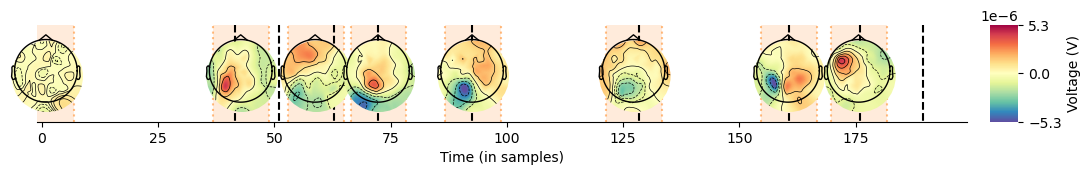

In [7]:
#Fitting
selected = init.fit_n(n_events, parameters=pars)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

## Random method

In reality, we do not know where the real events are. Thus, a better idea is to run a single model with several starting points and selecting the result with the best fit. This can be declared in the ```fit_n()``` function; here we estimate an example with 50 random starting points. We set `return_max` to False to get all models back, instead of only the winning one. 

Estimating 8 events model with 50 starting point(s)


  0%|          | 0/51 [00:00<?, ?it/s]

parameters estimated for 8 events model


Text(0, 0.5, 'Log-likelihood')

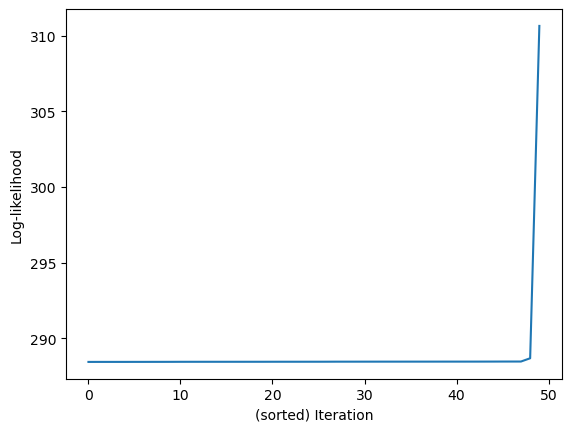

In [8]:
#NOTE: if you run this in VS code on a Mac in an interactive window, you might get strange behavior (running of previous processes) due to the multiprocessing. If so, set your multiprocessing start method to 'fork' (which is the default on Unix) by uncommenting the next two lines:
#import multiprocessing as mp
#mp.set_start_method("fork")

# Fitting
selected = init.fit_n(n_events, starting_points=50, return_max=False)#function to fit an instance of a 4 events model

plt.plot(selected.sortby('loglikelihood').loglikelihood)#Sorted starting point iteration based on log-likelihood
plt.xlabel('(sorted) Iteration')
plt.ylabel('Log-likelihood')

from the plot of the sorted log-likelihoods, it's clear that a few models are worse or better than most of the random drawn starting points. If we sort them by their lowest or highest LLikelihood then we see that the highest LLikelihood model is indeed the closest to the ground truth but still not perfect.

Note that given randomness, the close-to-perfect solution might not be found, you can give it a tryu and run these cells a coupe of time to see the impact of random starting point.

In [9]:
worst_to_best_sp = selected.sortby('loglikelihood').starting_points

Plotting the worst performing starting points

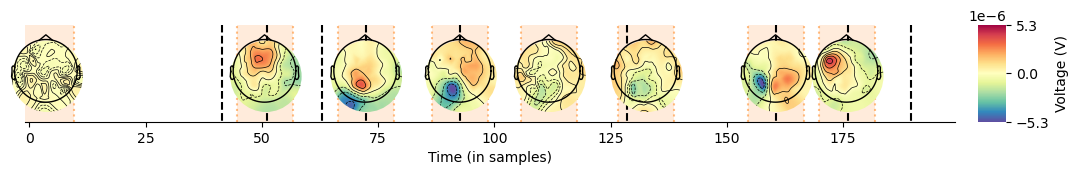

In [10]:
    hmp.visu.plot_topo_timecourse(epoch_data, selected.sel(starting_points=worst_to_best_sp[0]), info, magnify=1, sensors=False, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

Plotting the best performing starting points

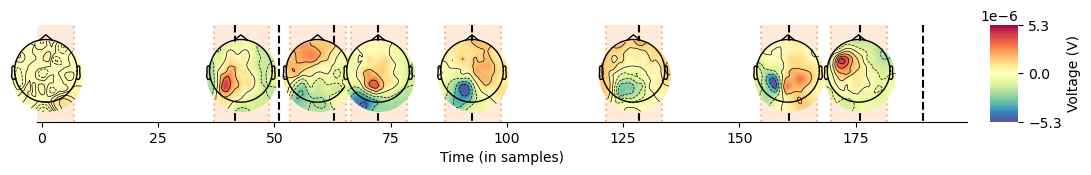

In [11]:
    hmp.visu.plot_topo_timecourse(epoch_data, selected.sel(starting_points=worst_to_best_sp[-1]), info, magnify=1, sensors=False, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As a side note, instead of recording all those starting points we can just take the most likely one directly by setting `return_max` to True.

But, by definition, the starting points are random: as a result they induce a lot of redundancy and you take the risk that some points in the parameter space remain unexplored as is the case here. Below we will explore better/additional solutions to this issue.

### Exercise 2:

What good solution for this can you think of? To illustrate where we are going to do, fit models by subsampling from 1 to 12 events (e.g. 2, 4, 10, 12) with default starting points.

Estimating 2 events model with 1 starting point(s)
parameters estimated for 2 events model


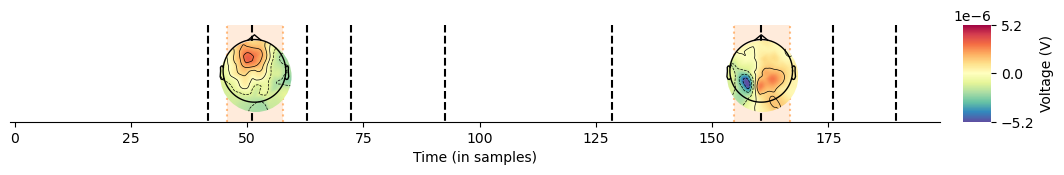

In [12]:
selected = init.fit_n(2)#Replace 2 with the desired number
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

## Backward estimation

Another solution than using random points is to first estimate a model with the maximal number of possible events that fit in RTs (referred to as 'the maximal model'), and then decrease the number of events one by one.

The idea is that genuine events will necessarily be found at the expected locations in the maximal model. Because the backward estimation method iteratively removes the weakest event (in terms of likelihood), only the 'strongest' events remain even if their location would have been hard to find with a single fit and default starting values.

In order to do this we will use the ```backward_estimation()``` function. This function first estimates the maximal model (defined based on the event width and the minimum reaction time), then estimates the max_event - 1 solution by iteratively removing one of the events and picking the next solution with the highest likelihood (for more details see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_hmp_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 event solution is reached. 

In [13]:
bests = init.backward_estimation(max_events=int(init.compute_max_events()))

Estimating all solutions for maximal number of events (10) with 1 pre-defined starting point and 0 starting points
Estimating all solutions for 9 events
Estimating all solutions for 8 events
Estimating all solutions for 7 events
Estimating all solutions for 6 events
Estimating all solutions for 5 events
Estimating all solutions for 4 events
Estimating all solutions for 3 events
Estimating all solutions for 2 events
Estimating all solutions for 1 events


Here we plot the resulting solutions going from the maximal possible number of events (16) all the way to a single event. 

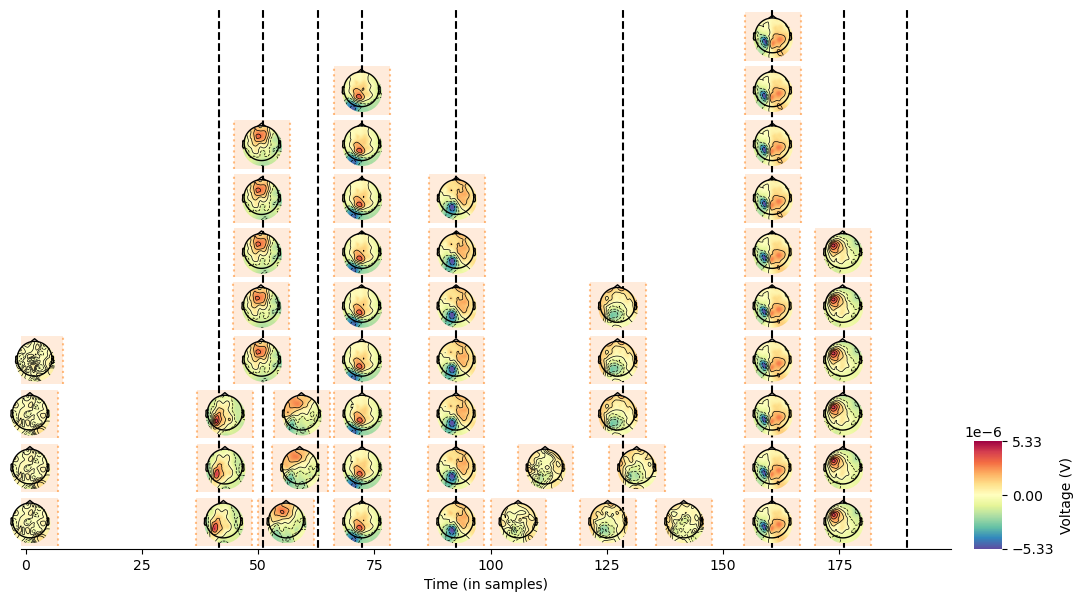

In [14]:
hmp.visu.plot_topo_timecourse(epoch_data, bests, info, sensors=False,
                    times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

As you can see, while most true events are found even with a lot of to-be estimated event, the 2nd one still escapes the estimation (to be fair that dataset is very hard as the 2nd is very close to the other ones). The reason is again linked to the starting points as the space between the 1th and the 3rd is not explored. A solution could be to just add random starting points to the maximal model but for the sake of time we skip that part.

From the solutions of the backward estimation we can select the number of events we originally wanted to estimate (which is still not the correct solution in this case):

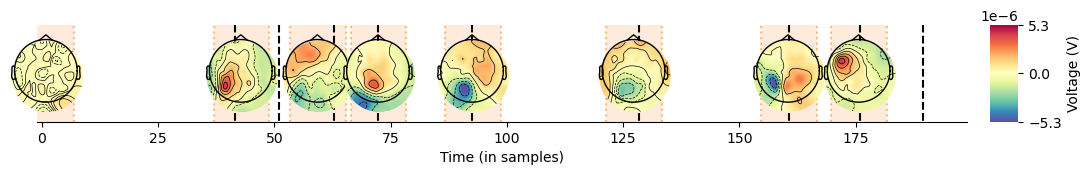

In [15]:
selected = bests.sel(n_events=n_events)
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

[!note] In all the previous cases we missed either the first or the second one, they are very close in time and thus hard to estimate. Next section shows how to recover these first events.

## Cumulative event fit

Instead of fitting an _n_ event model this method starts by fitting a 1 event model using each sample from the time 0 (stimulus onset) to the mean RT. Therefore it tests for the landing point of the expectation maximization algorithm given each sample as starting point and the likelihood associated with this landing point. As soon as a starting points reaches the convergence criterion, the function fits an _n+1_ event model and uses the next samples in the RT for the following event, etc.

  0%|          | 0/190 [00:00<?, ?it/s]


Event found at sample 42
Events at [ 42 189]
lkh change: inf
Transition event 1 found around sample 42

Event found at sample 63
Events at [ 42  63 189]
lkh change: 128.32255385297933
Transition event 2 found around sample 63

Event found at sample 94
Events at [ 42  63  94 189]
lkh change: 137.3497317892765
Transition event 3 found around sample 94

Event found at sample 129
Events at [ 42  63  93 129 189]
lkh change: 29.815463955760293
Transition event 4 found around sample 129

Event found at sample 161
Events at [ 42  63  93 127 161 189]
lkh change: 215.87139930320305
Transition event 5 found around sample 161

Event found at sample 178
Events at [ 42  63  93 127 159 178 189]
lkh change: 58.0215155833057
Transition event 6 found around sample 178

Event found at sample 177
Events at [ 42  63  91 114 135 159 177 189]
lkh change: -81.72545993937007

All events found, refitting final combination.
Estimating 6 events model
parameters estimated for 6 events model


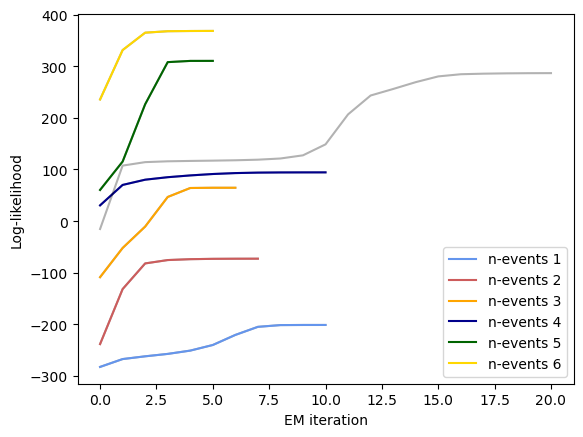

In [16]:
estimates = init.fit(diagnostic=True)

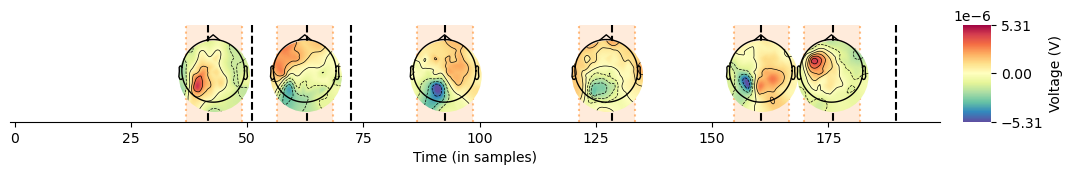

In [17]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, 
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

We're missing again two! This comes as the EM algorithm might skip a convergence point as it jumps from one local minima to the other because the next one had a higher likelihood. To overcome this we can look for smaller events to help HMP find them (see Appendix 3 from the [preprint](https://www.biorxiv.org/content/10.1101/2024.02.13.580102v3)):

  0%|          | 0/190 [00:00<?, ?it/s]


Event found at sample 43
Events at [ 43 189]
lkh change: inf
Transition event 1 found around sample 43

Event found at sample 52
Events at [ 41  52 189]
lkh change: 245.53706628269543
Transition event 2 found around sample 52

Event found at sample 63
Events at [ 41  51  63 189]
lkh change: 206.37513415785165
Transition event 3 found around sample 63

Event found at sample 73
Events at [ 41  51  63  73 189]
lkh change: 262.5939926383987
Transition event 4 found around sample 73

Event found at sample 93
Events at [ 41  51  63  73  93 189]
lkh change: 282.6212374668795
Transition event 5 found around sample 93

Event found at sample 127
Events at [ 41  51  63  73  93 127 189]
lkh change: 87.8004589581144
Transition event 6 found around sample 127

Event found at sample 161
Events at [ 41  51  63  73  93 128 161 189]
lkh change: 408.5816614007058
Transition event 7 found around sample 161

Event found at sample 176
Events at [ 41  51  63  73  93 128 161 176 189]
lkh change: 261.95525990

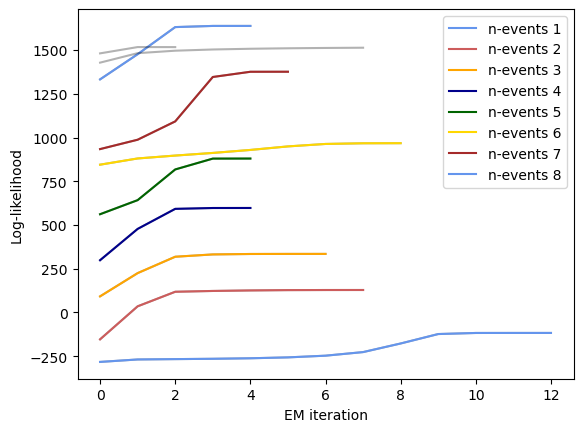

In [18]:
init = hmp.models.hmp(hmp_dat, event_width=25, cpus=cpus)#Initialization of the model
estimates = init.fit(diagnostic=True)

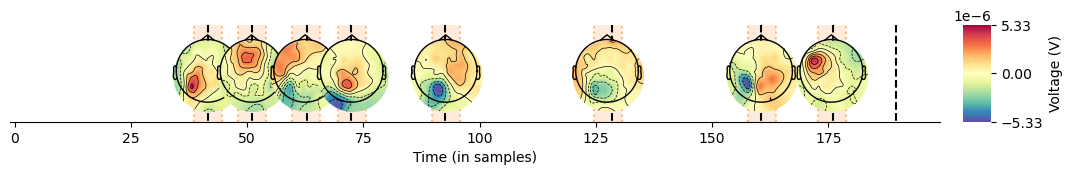

In [19]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, 
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

Now it's perfect! In fact, all previous methods will also work better (to some extent) if looking for smaller events. If however the searched events are too small, a single true event might be decomposed into several estimated events (try it yourself, here or in Tutorial 1) or check Appendix 3 from the [preprint](https://www.biorxiv.org/content/10.1101/2024.02.13.580102v3)

# Data saving

Once finished we can save fitted models using the dedicated command

In [20]:
hmp.utils.save(selected, 'selected.nc')

selected.nc saved


<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


And load the same way

In [21]:
estimates = hmp.utils.load('selected.nc')

/home/gweindel/miniconda3/envs/main_hmp/lib/python3.12/site-packages/xarray/core/dataarray.py:3107: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


In [22]:
estimates

<xarray.Dataset> Size: 1MB
Dimensions:              (stage: 11, parameter: 2, event: 10, component: 10,
                          samples: 295, em_iteration: 37,
                          trial_x_participant: 50)
Coordinates:
  * stage                (stage) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * parameter            (parameter) <U5 40B 'shape' 'scale'
  * event                (event) int64 80B 0 1 2 3 4 5 6 7 8 9
  * component            (component) int64 80B 0 1 2 3 4 5 6 7 8 9
  * samples              (samples) int64 2kB 0 1 2 3 4 5 ... 290 291 292 293 294
  * em_iteration         (em_iteration) int64 296B 0 1 2 3 4 ... 32 33 34 35 36
    rts                  (trial_x_participant) int64 400B 178 221 ... 189 210
    n_events             int64 8B 8
  * trial_x_participant  (trial_x_participant) object 400B MultiIndex
  * participant          (trial_x_participant) <U2 400B 'S0' 'S0' ... 'S0' 'S0'
  * trials               (trial_x_participant) int64 400B 0 1 2 3 ... 47 48 49
Data variables:
    loglikelihood        float64 8B 310.9
    parameters           (stage, parameter) float64 176B 2.0 1.114 ... nan nan
    magnitudes           (event, component) float64 800B 0.2971 -0.299 ... nan
    eventprobs           (trial_x_participant, samples, event) float64 1MB 0....
    traces               (em_iteration) float64 296B 299.3 308.9 ... nan nan
    param_dev            (em_iteration, stage, parameter) float64 7kB 2.0 ......
Attributes:
    sfreq:                250.0
    event_width_samples:  12
    tolerance:            0.0001
    maximization:         1
    method:               backward

Or even only save the estimated event probabilities as .csv files to use in a dataframe format

In [23]:
hmp.utils.save_eventprobs(selected.eventprobs, 'selected_eventprobs.csv')

Saved at selected_eventprobs.csv
